# OCR recognition with Transformers (Testing Phase)

#### important libraries

In [ ]:
import requests 
import pandas as pd
import numpy as np
import os


from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from math import ceil, floor

import warnings
warnings.filterwarnings('ignore')

#### specify the FineTune model path (Pytorch model) and load the processor and model of ViT

In [29]:

#specify the FineTune model path (Pytorch model)
model_path = r"C:\Users\A\Classification Aico\modelling\training\model\mnist_dataset_1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten") 
model = VisionEncoderDecoderModel.from_pretrained(model_path,local_files_only=True).to(device) 

#### Loop over all the single digits images and generate them with the processor and model

In [31]:

images = "C:\\Users\\A\\datasets\\Thesis\\28x28\\"
df_digit = pd.DataFrame()
df_temp = pd.DataFrame(columns=['Student','Question','Subdigit','Pred'])
for img in os.listdir(images):
    #image = Image.open(images+img).convert("RGB")
    image = cv2.imread(images+img)
    imageinv = cv2.bitwise_not(image)z
    pixel_values = processor(imageinv, return_tensors="pt").pixel_values
    generated_ids = model.generate(pixel_values.to(device))
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    name = img.split('_')
    data = {'Student': name[0],'Question': name[1], 'Subdigit': name[2].split('.')[0],'Pred': int(generated_text)}
    df_digit = df_digit.append(data,ignore_index=True)
    

#### Read the custom labels for testing purpose (get accuracy score)

In [32]:

df_labels = pd.read_csv(r'C:\Users\A\Classification Aico\modelling\testing\input\custom_label.csv',dtype=str)

In [33]:
df_labels

,Student,Question,Subdigit,Expected
0,exp1,2,0,2
1,exp1,2,1,7
2,exp1,3,0,4
3,exp1,3,1,8
4,exp1,4,0,3
...,...,...,...,...
3414,exp73,19,1,5
3415,exp73,19,2,5
3416,exp73,20,0,1
3417,exp73,20,1,4


In [34]:
df_merge = pd.merge(df_digit,df_labels,how='inner')

In [35]:
df_digit

,Student,Question,Subdigit,Pred
0,exp10,10,0,4
1,exp10,10,1,0
2,exp10,11,0,1
3,exp10,11,1,5
4,exp10,11,2,0
...,...,...,...,...
3421,exp9,8,1,5
3422,exp9,8,2,3
3423,exp9,9,0,6
3424,exp9,9,1,6


In [36]:
df_merge = df_merge.dropna()
df_merge.Pred = pd.to_numeric(df_merge.Pred, errors='coerce')
df_merge.Expected = pd.to_numeric(df_merge.Expected, errors='coerce')

# only select single digits
df_merge = df_merge[df_merge.Expected < 10].reset_index()



In [39]:
df_merge.groupby(['Expected'])['index'].count()

Expected
0    321
1    301
2    278
3    375
4    329
5    218
6    290
7    261
8    304
9    130
Name: index, dtype: int64

#### Create and print the classification report

In [40]:
y_true = df_merge.Expected
y_pred = df_merge.Pred
cf_matrix = confusion_matrix(y_true, y_pred)


In [43]:
print(classification_report(y_pred,y_true))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       337
           1       0.98      0.98      0.98       302
           2       0.98      0.90      0.94       303
           3       1.00      0.97      0.98       385
           4       0.96      0.98      0.97       323
           5       1.00      0.98      0.99       222
           6       0.98      0.99      0.98       286
           7       0.90      0.96      0.93       244
           8       0.88      0.98      0.93       275
           9       0.93      0.93      0.93       130

    accuracy                           0.96      2807
   macro avg       0.96      0.96      0.96      2807
weighted avg       0.96      0.96      0.96      2807



In [44]:
report = classification_report(y_true, y_pred, output_dict=True)
report['accuracy']

0.9608122550765942

#### Plot the confusion matrix

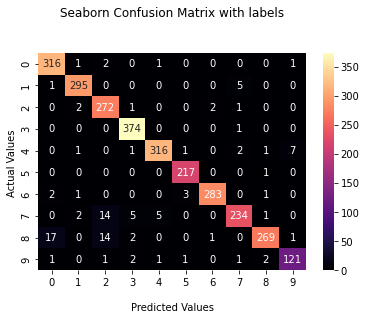

In [45]:
ax = sns.heatmap(cf_matrix , annot=True, cmap='magma',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()

#### Show all miss classified digits

In [49]:
df_miss = df_merge[(df_merge['Pred'] != df_merge['Expected'])]

In [50]:
df_miss

,index,Student,Question,Subdigit,Pred,Expected
16,19,exp10,17,1,7,4
36,40,exp10,6,2,4,7
144,171,exp13,13,0,8,9
148,175,exp13,14,1,2,8
209,245,exp14,2,1,2,7
...,...,...,...,...,...,...
2767,3370,exp9,12,0,2,8
2768,3371,exp9,12,1,4,7
2776,3379,exp9,15,1,6,8
2789,3395,exp9,20,2,7,2


#### Plot all miss classification of the model

In [ ]:
import cv2
import matplotlib.pyplot as plt
path = r'C:\Users\A\datasets\Thesis\28x28'

for index in df_miss.index:
    
    image = cv2.imread(path+'//'+index[['Student','Question','Subdigit']].apply("_".join,axis=1)+'.jpg')
    imagem = cv2.bitwise_not(image)
    plt.imshow(imagem)
    plt.show()